# Analysis of MovieLens Data

**Created by Phillip Efthimion, Scott Payne, Gino Varghese and John Blevins**

*MSDS 7331 Data Mining - Section 403 - Lab 3*

# Business Understanding

In this notebook publicly available data from MovieLens (movielens.org) will be analyzed. MovieLens is a non-commercial website that provides personalized movie recommendations. The dataset was assembled by GroupLens (grouplens.org) and includes movie ratings data created by 671 users between January 09, 1995 and October 16, 2016. The data includes 100,004 ratings and 1,296 tag applications across 9,125 movies. The users were selected at random and each user rated at least 20 movies. No demographic data was collected for the users. The data is provided for public consumption at http://grouplens.org/datasets/ for the purposes of analysis and study.

The movie ratings data is signifcant as online movie providers are in constant competition with one another to best market their content to consumers. Understanding their consumer market is vital to providing appropriate content choices for users to keep them interested and engaged with the provider's services. Content providers are increasingly employing recomendation systems to help identify and target content. Recommender systems can help providers better predict what titles may be of interest to individual consumers based on their past history and the history of others with similar interests.

The MovieLens dataset provides sufficient data points to model a recommender system using either collaborative filtering, content-based filtering or a hybrid combination of the two. In a collaborative filtering approach the past ratings of individual users as well as the ratings provided by other users can be considered for the purposes of making recommendations. This approach however may suffer from the "Cold Start" problem where larger amounts of information are required to make accurate recommendations. For this analysis we are utilizing a subset of the larger MovieLens data due to processing requirements. A larger study may be conducted using the full compliment of data given the avaialability of additional resources. As an alternative to the collaborative filtering approach a content-based filtering model may be desireable where the genre and tag information are used to filter out recommendations based on discrete specific charateristics. This approach may work well right away but could be limited to the subset of characteritic data available during the initial seeding and may not scale.

The effectiveness of the recommender algorithms will be measured by implementing a cross-validation split of testing and training data to then compare the Root Mean Square Errors (RMSE) and determine how well the models perform. Precision and recall will also be assessed to determine the quality of the alogorthm. In general the RMSE should be minimized while precision and recall should be consistently maximized. For this analysis several model types will be fitted including item similarity and factorization models. The tag and genre can also be side-loaded into an additional content-based model and used to emphasize these attributes in the recommendation process. Ultimately the use of these models will allow us to predict with high confidence what movies users will like in an attempt to recommend or improve the stakeholder's existing algorithm. The model is quite capable of being extend to certain scenarios such as building a recommended for a new user versus for a user who has consumed proivder content for a longer period of time. This is one of many business use cases for the algorithm.


# Data Understanding

This data was compiled from movielens.org by F. Maxwell Harper and Joseph A. Kinston from the University of Minnesota. It contains 100,004 ratings by 671 unique users on 9,125 movies. These movies were all rated between January 1995 and October 2016. Each of the 671 users rated at least 20 movies. This data does not come from the full dataset, and is on a partial representation of the complete one. There is no duplicate data. There are some movies that may have the same title. However, they were released different years and have different unique movie ID numbers. Therefore, they are not  actually duplicates. For example, ‘Ghostbusters (1984)’ and ‘Ghostbusters (2016)’ with movie ID numbers 2716 and 160080 respectively. 

The data comes from multiple .cvs files that together make up a the information that we will be using for our analysis. The file ‘movies.csv’ contain 3 attributes. The movie ID, the title of the movie, and what genres the movie falls under. The movie ID is a unique identifier that is used as a primary key for identification between the datasets. The attribute ‘title’ contains both the title of a movie and the year that it was released. Again, since the attribute ‘title’ contains both the movie’s title and the year that movie was released, we do not have to worry about duplicates such as ‘Ghostbusters’. The attribute genre is a list of genres that a film can fall under. In the cases that a film may have elements of more then one genre, they all will be contained in this column separated by a ‘|’. The genres fall under a list of 18 along with a 19th being no genre listed. The file ‘ratings.csv’ contains 4 attributes. Those are the user ID, the movie ID, the rating that the specific user gave the film, and the timestamp. The user ID, like the movie ID acts as a primary key to uniquely identify each user. The attribute ‘Ratings’ is the rating from 1 to 5, with 5 being the highest, that the user rated the movie. These ratings do not have to be whole numbers. For example, a movie can be rated a 3.5. The timestamp is the amount of seconds since January 1st, 1970. It is supposed to be a timeline of when each of these ratings occurred. Day, month, and year of each rating is not provided, but from the timestamp it could be calculated. As it is, it functions as a time series. 

In [1]:
%matplotlib inline

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy
import seaborn as sns

data_ratings = pd.read_csv('data/ml-latest-small/ratings.csv')
data_movies = pd.read_csv('data/ml-latest-small/movies.csv')

data_ratings.head()
# data_movies.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [2]:
data_ratings.describe()
data_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
userId       100004 non-null int64
movieId      100004 non-null int64
rating       100004 non-null float64
timestamp    100004 non-null int64
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


#### There are no 'NA' values in the movies.csv data file

In [3]:
data_movies.columns[data_movies.isnull().any()]

Index([], dtype='object')

#### There are no 'NA' values in the ratings.csv data file

In [4]:
data_ratings.columns[data_ratings.isnull().any()]

Index([], dtype='object')

A box plot is created to get an initial idea about how the movies were rated in general. The box plot shows that the average rating of a movie was a 3.5 out of 5 stars. Also, fifty percent of the ratings given were between a 3 and 4. Almost all of the movies were rated between a 1.5 and 5 though there are some outliers that were movies  rated a 0.5 and 1 out of 5. No movies were rated a 0 out of 5 stars. It is unfair to think that these were mistakes, instead it could be that people did not enjoy the movie the were watching.

Axes(0.125,0.125;0.775x0.775)


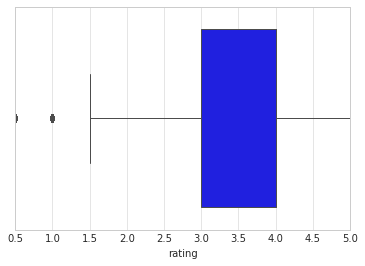

In [5]:
# Boxplot of Ratings using seaborn package

sns.set_style("whitegrid")

ax = sns.boxplot(x="rating", data = data_ratings)
print(ax)

Each user had to rate at least 20 movies to be included in this dataset. This was however only at a minimum and some users rated many more titles. Ten of the users rated over 1000 movie titles with one individual rating over 2000 different movies.  The user who rated over 2000 movies gave out an average rating of 3.3. 

In [6]:
data_ratings.userId.value_counts()

547    2391
564    1868
624    1735
15     1700
73     1610
452    1340
468    1291
380    1063
311    1019
30     1011
294     947
509     923
580     922
213     910
212     876
472     830
388     792
23      726
457     713
518     707
461     696
232     682
102     678
262     676
475     655
306     645
119     641
654     626
358     617
529     604
       ... 
356      21
579      21
319      20
14       20
448      20
583      20
76       20
310      20
1        20
498      20
438      20
638      20
651      20
325      20
399      20
289      20
209      20
296      20
445      20
337      20
249      20
540      20
604      20
668      20
657      20
221      20
444      20
484      20
35       20
485      20
Name: userId, dtype: int64

The plot below shows the distribution of ratings over time the most frequent rater provided for each film.

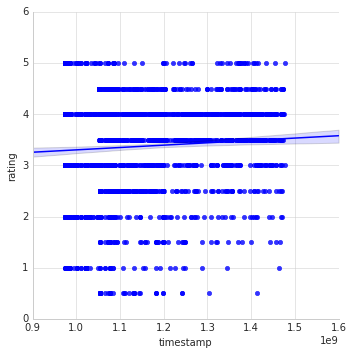

In [7]:
top_user = data_ratings[data_ratings.userId == 547]

top_ratings_box = sns.lmplot(x='timestamp', y='rating', data=top_user)

print(top_ratings_box)

In [8]:
top_user.describe()

,userId,movieId,rating,timestamp
count,2391.0,2391.000000,2391.000000,2.391000e+03
mean,547.0,25546.874529,3.366792,1.138885e+09
std,0.0,37267.186098,1.073516,1.415010e+08
min,547.0,1.000000,0.500000,9.747771e+08
25%,547.0,2479.500000,3.000000,1.022680e+09
50%,547.0,5339.000000,3.500000,1.093860e+09
75%,547.0,39397.500000,4.000000,1.224439e+09
max,547.0,163949.000000,5.000000,1.476588e+09


The movie that was rated the most frequently was Forest Gump with 341 votes. The top 5 frequently rated movies were Forest Gump, Pulp Fiction, Shawshank Redemption, Silence of the Lambs, and Star Wars: Episode IV - A New Hope. These movies were all realeased in the 1990s which was around the general adoption of the internet. It could be that these movies were rated more often and higher in the beginning when internet accessibility was taking hold.  These movies can be seen below by matching the 'movieId' and 'title' fields in the movie.csv file.  

In [9]:
# Which movies were rated the most
data_ratings.movieId.value_counts()



# 356    Forrest Gump
# 296    Pulp Fiction
# 318    Shawshank Redemption
# 593    Silence of the Lambs
# 260    Star Wars: Episode IV - A New Hope

356       341
296       324
318       311
593       304
260       291
480       274
2571      259
1         247
527       244
589       237
1196      234
110       228
1270      226
608       224
2858      220
1198      220
780       218
1210      217
588       215
457       213
2959      202
590       202
50        201
47        201
4993      200
858       200
150       200
364       200
380       198
32        196
         ... 
98160       1
6109        1
120805      1
131168      1
73860       1
60674       1
104595      1
133281      1
155820      1
26797       1
47287       1
8420        1
61250       1
3870        1
5917        1
1759        1
26323       1
32464       1
65216       1
65088       1
73276       1
7708        1
69118       1
110058      1
140763      1
48520       1
111913      1
1311        1
27922       1
2049        1
Name: movieId, dtype: int64

In [10]:
print(data_movies.title[data_movies.movieId==356])
print(data_movies.title[data_movies.movieId==296])
print(data_movies.title[data_movies.movieId==318])
print(data_movies.title[data_movies.movieId==593])
print(data_movies.title[data_movies.movieId==260])

321    Forrest Gump (1994)
Name: title, dtype: object
266    Pulp Fiction (1994)
Name: title, dtype: object
284    Shawshank Redemption, The (1994)
Name: title, dtype: object
525    Silence of the Lambs, The (1991)
Name: title, dtype: object
232    Star Wars: Episode IV - A New Hope (1977)
Name: title, dtype: object


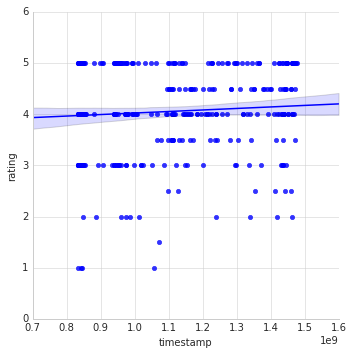

In [11]:
# Forest Gump Ratings over time

Gump_ratings = data_ratings[data_ratings.movieId == 356]

x356 = sns.lmplot(x='timestamp', y='rating', data=Gump_ratings)
print(x356)

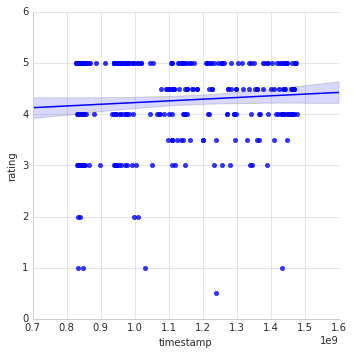

In [12]:
# Pulp Fiction ratings over time
Pulp_ratings = data_ratings[data_ratings.movieId == 296]

x296 = sns.lmplot(x='timestamp', y='rating', data=Pulp_ratings)
print(x296)

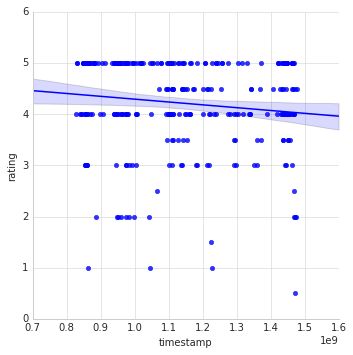

In [13]:
# Star Wars: Episode IV - A New Hope ratings over time
Shaw_ratings = data_ratings[data_ratings.movieId == 260]

x260 = sns.lmplot(x='timestamp', y='rating', data=Shaw_ratings)
print(x260)

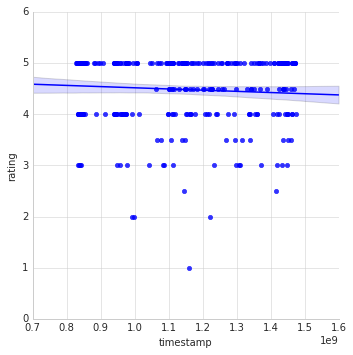

In [14]:
# Shawshank Redemption ratings over time
Shaw_ratings = data_ratings[data_ratings.movieId == 318]

x318 = sns.lmplot(x='timestamp', y='rating', data=Shaw_ratings)
print(x318)

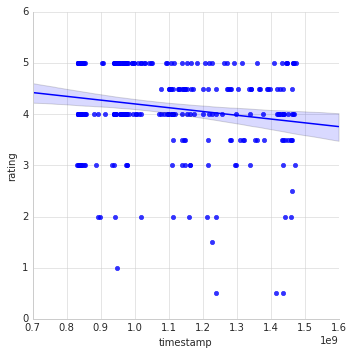

In [15]:
# Silence of the Lambs ratings over time
Lambs_ratings = data_ratings[data_ratings.movieId == 593]

x593 = sns.lmplot(x='timestamp', y='rating', data=Lambs_ratings)
print(x593)

The other movie in the top 5 was the first Star Wars movie released. It is different from many of the rest in that it was released a lot earlier. It is has a negative slope. This means that as time has gone on, it has received worse ratings then it did previously. It is possible that this could be due to the Star Wars prequel series, Ep. I, II, & III, which had on average, lower ratings. 

# Modeling and Evaluation
## Collaborative Filtering 

The following code will import graphlab module and create a canvas target within the notebook.

In [16]:
import graphlab as gl
from datetime import datetime
from IPython.display import display
from IPython.display import Image
import pandas as pd

# sets the output of built in visualizations to the notebook instead of the browser based canvas utility
gl.canvas.set_target('ipynb')

<br>
Reading in data file into SFrame for analysis.
Timestamp was removed and year, title and genres were extrated into there own fields

In [17]:
# Reads the movie ratings data directly into an SFrame
data_ratings = gl.SFrame.read_csv("data/ml-latest-small/ratings.csv", column_type_hints={"rating":float})
data_movies = gl.SFrame.read_csv("data/ml-latest-small/movies.csv", column_type_hints={"movieId":int})

#limit to movie if and title from data_movies
data_final = data_movies[['movieId','title']]

#data_final['title'] = data_final['movieId'].apply(str)+','+ data_final['title'].apply(str)
#data_movies['movieId']
#append['movieId','title']
#sf['col1'].apply(str) + ',' + sf['col2'].apply(str)


# Removes timestamp column
data_ratings.remove_column('timestamp')

# Extract year, title, and genre
data_movies['year'] = data_movies['title'].apply(lambda x: x[-5:-1])
data_movies['title'] = data_movies['title'].apply(lambda x: x[:-7])
data_movies['genres'] = data_movies['genres'].apply(lambda x: x.split('|'))
data_ratings = data_ratings.join(data_final, on='movieId')

#data_ratings['timestamp'] = data_ratings['timestamp'].astype(datetime)
#data_movies = data_movies.join(data_rating, on='movieId')
#data_final = data_final.join(data_ratings, on='movieId')


#Setting up for analysis
data_final = data_ratings

This non-commercial license of GraphLab Create for academic use is assigned to gjvarghese@smu.edu and will expire on August 05, 2018.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1502674285.log


Finished parsing file /home/sam/Documents/DataMining/Lab3/MSDS7331-GroupProject/data/ml-latest-small/ratings.csv

Parsing completed. Parsed 100 lines in 0.130763 secs.

Finished parsing file /home/sam/Documents/DataMining/Lab3/MSDS7331-GroupProject/data/ml-latest-small/ratings.csv

Parsing completed. Parsed 100004 lines in 0.112433 secs.

Finished parsing file /home/sam/Documents/DataMining/Lab3/MSDS7331-GroupProject/data/ml-latest-small/movies.csv

Parsing completed. Parsed 100 lines in 0.040433 secs.

Finished parsing file /home/sam/Documents/DataMining/Lab3/MSDS7331-GroupProject/data/ml-latest-small/movies.csv

Parsing completed. Parsed 9125 lines in 0.024581 secs.

<br>
Summary statistics for the SFrame

In [18]:
# Summary statistics for SFrame
data_final.show()

<br>
Visualize data in SFrame
      
GraphLab Canvas provided a GUI Web iterface, to explore interactive visuals and perform exploratory data analysis on the SFrame.

In [19]:
from IPython.display import display
from IPython.display import Image
import graphlab.aggregate as agg


#gl.canvas.set_target('browser')
gl.canvas.set_target('ipynb')

count_rating = data_final.groupby(key_columns='userId', operations={'rating': agg.COUNT()})

count_movie = data_final.groupby(key_columns='userId', operations={'movieId': agg.COUNT()})

<br>
ratings vs movieid, to identify the popular rating, how many users rated movies, into 5 rating categories.

In [20]:
data_final.show(view="Bar Chart", x='rating', y='movieId')

<br>
Identify the number of movies that was watched by each user, 

In [21]:
data_final.show(view="Bar Chart", x="userId", y="count_movie")

<br>
To see how many users have watched each movie, in logarthemic scale..

In [22]:
data_final.show(view="Heat Map", x="userId", y="count_rating")

<br>
### Train and adjust parameters

## Simple Recomender Model
GraphLab is able to create a recommender model from an SFrame and chooses the type of model that best fits the data. The only requirements are that the SFrame contain a column with Item ids and a column with User ids. An optional target value can be specified such as a rating, if no target is specified, then the model will be based on item-item similarity. 

In [23]:
# Because no model is specified, GraphLab will select the most approriate model
auto_selected_model = gl.recommender.create(data_final, user_id="userId", item_id="title", target="rating")

# results = model_ratings.recommend(users=None, k=5)
# results = model_ratings.recommend(users=None, k=3)
# model_ratings.save("my_model")

Recsys training: model = ranking_factorization_recommender

Preparing data set.

Data has 100004 observations with 671 users and 9064 items.

Data prepared in: 0.431386s

Training ranking_factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 32       |

| regularization                 | L2 Regularization on Factors                     | 1e-09    |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-09    |

| ranking_regularization         | Rank-based Regularization Weight                 | 0.25     |

| max_iterations                 | Maximum Number of Iterations                     | 25       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 12500 / 100004 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 16.6667           | Not Viable                               |

| 1       | 4.16667           | Not Viable                               |

| 2       | 1.04167           | Not Viable                               |

| 3       | 0.260417          | Not Viable                               |

| 4       | 0.0651042         | 1.75189                                  |

| 5       | 0.0325521         | 1.31717                                  |

| 6       | 0.016276          | 1.79617                                  |

| 7       | 0.00813802        | 1.96272                                  |

| 8       | 0.00406901        | 2.08624                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0325521         | 1.31717                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 152us        | 2.19495           | 1.05805               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 342.082ms    | 1.74223           | 0.982428              | 0.0325521   |

| 2       | 624.226ms    | 1.57531           | 0.948856              | 0.0325521   |

| 3       | 889.183ms    | 1.55697           | 0.967938              | 0.0325521   |

| 4       | 1.17s        | 1.50576           | 0.960242              | 0.0325521   |

| 5       | 1.46s        | 1.46311           | 0.956282              | 0.0325521   |

| 6       | 1.75s        | 1.56456           | 0.997925              | 0.0325521   |

| 10      | 2.89s        | 1.39029           | 0.910779              | 0.0325521   |

| 11      | 3.25s        | 1.36063           | 0.903031              | 0.0325521   |

| 15      | 4.50s        | 1.29355           | 0.883296              | 0.0325521   |

| 20      | 6.00s        | 1.26884           | 0.872192              | 0.0325521   |

| 25      | 7.73s        | 1.27393           | 0.876097              | 0.0325521   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 1.25916

Final training RMSE: 0.858607

### Simple code, powerful results 
With a simple line of code, GraphLab is able to examine the data and build a recommender model with optimized parameters. Because we are interested in how different recommender models perform, we will look at a few of the recommendation models in GraphLab and see how well we can optimize the parameters.


### Train and Compare 
Before we build our recommender models and optimize them, we need to create a cross-validation split of testing and training data so that we can determine how well our models are performing.

In [24]:
#80% train and 20% for testing 
train, test = gl.recommender.util.random_split_by_user(data_final,
                                                    user_id="userId", item_id="title",
                                                    max_num_users=150, item_test_proportion=0.2)

## Item-Item Similarity

In [25]:
gl.canvas.set_target('ipynb') 

# Create a recommender that uses item-item similarities based on users in common.
m1 = gl.recommender.item_similarity_recommender.create(train, 
                                  user_id="userId", 
                                  item_id="title",
                                  target="rating",
                                  #item_data=
                                  #only_top_k=5,
                                  only_top_k=3,
                                  #similarity_type="sine")                    
                                  similarity_type="cosine")


rmse_results = m1.evaluate(test)

Recsys training: model = item_similarity

Warning: Ignoring columns movieId;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 95889 observations with 671 users and 8926 items.

Data prepared in: 0.204102s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 12.463ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 245.553ms                           | 0                | 0               |

| 1.05s                               | 100              | 8926            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 1.07327s


Precision and recall summary statistics by cutoff
+--------+----------------+-----------------+
| cutoff | mean_precision |   mean_recall   |
+--------+----------------+-----------------+
|   1    |      0.42      |  0.026990153554 |
|   2    | 0.363333333333 | 0.0445209051708 |
|   3    | 0.342222222222 | 0.0629911442581 |
|   4    | 0.311666666667 | 0.0794563728305 |
|   5    | 0.286666666667 | 0.0889696618367 |
|   6    | 0.284444444444 |  0.106018474765 |
|   7    | 0.273333333333 |  0.115521425446 |
|   8    | 0.260833333333 |  0.12222851154  |
|   9    | 0.25037037037  |  0.130522563254 |
|   10   | 0.242666666667 |  0.135954042939 |
+--------+----------------+-----------------+
[10 rows x 3 columns]

('\nOverall RMSE: ', 3.699563460505805)

Per User RMSE (best)
+--------+-------+---------------+
| userId | count |      rmse     |
+--------+-------+---------------+
|  310   |   2   | 2.02297005609 |
+--------+-------+---------------+
[1 rows x 3 columns]


Per User RMSE (worst)


In [26]:
#nearest_items = m1.get_similar_items()
#m1_nearest_items = gl.item_similarity_recommender.create(train, 
#                                  user_id="userId", 
#                                  item_id="movieId", 
#                                  target="rating",
#                                  #only_top_k=5,
#                                  only_top_k=3,
#                                  #similarity_type="sine")                    
#                                  similarity_type="cosine",
#                                  nearest_items= nearest_items)
# Interactively evaluate and explore recommendations
#training_data, validation_data = gl.recommender.util.random_split_by_user(actions, 'userId', 'movieId')

### Item Similarity Model Analysis
The Item Similarity Model creates a  content-based recommender model in which the similarity between the items recommended is determined by the content of those items rather than learned from user interaction data. Because a target rating parameter is specified, the model will try to predict if an item will be “highly rated” by the user. The RMSE in this case is based on the success of the model at recommending items that the user also “rated highly”. The precision recall is looking at if the user interacted with the movies that were recommended based on the item similarity model.

The overall RMSE = 3.69

A model that takes into account user interactions should be more effective at predicting how a user will rate a movie. 

### Recommendation for Item-Item Similarity for user = 547
The top recommendations for individual users shows what movies are being recommended and what their objective score is.

<br>
User who watched the most movies in the data set

In [27]:
m1.recommend(users=["547"])
#recommender.factorization_recommender.FactorizationRecommender.recommend(users='547')

userId,title,score,rank
547,"Terminator, The (1984)",0.0080570833347,1
547,"Lord of the Rings: TheTwo Towers, The (2002) ...",0.00439381068444,2
547,Panic Room (2002),0.0038962301127,3
547,"Great Dictator, The(1940) ...",0.00383963461752,4
547,"Van, The (1996)",0.0036934840036,5
547,"Lord of the Rings: TheReturn of the King, The ...",0.00337444701388,6
547,Different for Girls(1996) ...,0.00302806597582,7
547,Shadowlands (1993),0.00299292954876,8
547,American Pie (1999),0.00295614558052,9
547,Star Wars: Episode IV - ANew Hope (1977) ...,0.00293037648083,10


<br>
User who watched the least movies in the data set

In [28]:
m1.recommend(users=["1"])

userId,title,score,rank
1,"Last Picture Show, The(1971) ...",0.149531364441,1
1,Five Easy Pieces (1970),0.14846546948,2
1,"Player, The (1992)",0.143601194024,3
1,"Purple Rose of Cairo, The(1985) ...",0.140900701284,4
1,Galaxy Quest (1999),0.127801269293,5
1,"Dark Crystal, The (1982)",0.126533269882,6
1,Alien (1979),0.124502051622,7
1,Cinderella (1950),0.115801099688,8
1,Network (1976),0.115082070231,9
1,"Big Chill, The (1983)",0.111308336258,10


## Recommender Model Exploration
Graphlab has a built in interface view to visualize data in another tab, by doing this we were able to verfiy the results above were accurate and explore the features and output of the model. This tool is extremely useful because it saves you the time of running code to examine each aspect and feature of the model. The code below opens this model overview in a new tab.

In [29]:
# Interactively evaluate and explore recommendations
#view = m1.views.overview (observation_data=train,
#                           validation_set=test,
#                            user_data=data_final,
#                            user_name_column='userId',
#                            item_data=data_final,
#                            item_name_column='title' 
#                            )
#                            #item_url_column='url')
#view.show()'''

## Ranking Factorization
The Factorization Recommender trains a model capable of predicting a score for each possible combination of users and items. The internal coefficients of the model are learned from known scores of users and items. Recommendations are then based on these scores.

In [30]:
# Model that learns latent factors for each user and item and uses them to make rating predictions
m2 = gl.recommender.ranking_factorization_recommender.create(train, 
                                  user_id="userId", 
                                  item_id="title", 
                                  target="rating")

rmse_results = m2.evaluate(test)

Recsys training: model = ranking_factorization_recommender

Preparing data set.

Data has 95889 observations with 671 users and 8926 items.

Data prepared in: 0.195224s

Training ranking_factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 32       |

| regularization                 | L2 Regularization on Factors                     | 1e-09    |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-09    |

| ranking_regularization         | Rank-based Regularization Weight                 | 0.25     |

| max_iterations                 | Maximum Number of Iterations                     | 25       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 11986 / 95889 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 16.6667           | Not Viable                               |

| 1       | 4.16667           | Not Viable                               |

| 2       | 1.04167           | Not Viable                               |

| 3       | 0.260417          | Not Viable                               |

| 4       | 0.0651042         | 1.90041                                  |

| 5       | 0.0325521         | 1.51649                                  |

| 6       | 0.016276          | 1.79776                                  |

| 7       | 0.00813802        | 1.97017                                  |

| 8       | 0.00406901        | 2.06493                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0325521         | 1.51649                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 242us        | 2.19241           | 1.05744               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 450.526ms    | 1.95504           | 1.05547               | 0.0325521   |

| 2       | 833.209ms    | 2.01112           | 1.11561               | 0.0325521   |

| 3       | 1.19s        | 1.70178           | 0.987235              | 0.0325521   |

| 4       | 1.54s        | 1.59925           | 0.965106              | 0.0325521   |

| 5       | 1.87s        | 1.54847           | 0.954839              | 0.0325521   |

| 6       | 2.17s        | 1.52255           | 0.951707              | 0.0325521   |

| 10      | 3.73s        | 1.46005           | 0.936224              | 0.0325521   |

| 11      | 4.09s        | 1.45715           | 0.93575               | 0.0325521   |

| 15      | 5.87s        | 1.68675           | 0.987361              | 0.0325521   |

| 20      | 7.57s        | 1.43684           | 0.932698              | 0.0325521   |

| 25      | 9.34s        | 1.40331           | 0.927397              | 0.0325521   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 1.38065

Final training RMSE: 0.910021


Precision and recall summary statistics by cutoff
+--------+----------------+------------------+
| cutoff | mean_precision |   mean_recall    |
+--------+----------------+------------------+
|   1    | 0.173333333333 | 0.00935041581384 |
|   2    | 0.146666666667 | 0.0137639868602  |
|   3    |      0.14      | 0.0216969483192  |
|   4    | 0.151666666667 | 0.0321545691813  |
|   5    | 0.141333333333 | 0.0368151813327  |
|   6    | 0.137777777778 |  0.042406988983  |
|   7    | 0.131428571429 | 0.0464896047621  |
|   8    |     0.1225     | 0.0487369122661  |
|   9    | 0.124444444444 | 0.0547448587701  |
|   10   | 0.120666666667 |  0.058859769537  |
+--------+----------------+------------------+
[10 rows x 3 columns]

('\nOverall RMSE: ', 1.1761141173991523)

Per User RMSE (best)
+--------+-------+----------------+
| userId | count |      rmse      |
+--------+-------+----------------+
|  347   |   2   | 0.415035549917 |
+--------+-------+----------------+
[1 rows x 3 columns]


Pe

### Ranking Factorization Model Analysis
This model tries to recommend items that are both similar to the items in a user's dataset and, if rating information is provided, those that would be rated highly by the user. It tends to predict ratings with less accuracy than the non-ranking factorization_recommender, but it tends to do much better at choosing items that a user would rate highly. This is because it also penalizes the predicted rating of items that are significantly different from the items a user has interacted with. In other words, it only predicts a high rating for user-item pairs in which it predicts a high rating and is confident in that prediction.

Overall RMSE = 1.1761141173991523

### Recommendation for Ranking Factorization
We can see that this list of recommendations is significantly different from the one generated by the item similarity model. It is important to look at the recommendations to understand how changing the model can change what is being recommended. The user with only 20 rated movies is recommended much "safer" popular films that the model is more confident the user will like.  

<br>
User who watched the most movies in the data set

In [31]:
m2.recommend(users=["547"])

userId,title,score,rank
547,"Lord of the Rings: TheReturn of the King, The ...",3.55961347287,1
547,Spirited Away (Sen toChihiro no kamikakushi) ...,3.46592526798,2
547,"Incredibles, The (2004)",3.44799896245,3
547,"Lord of the Rings: TheTwo Towers, The (2002) ...",3.44156379168,4
547,"Princess Bride, The(1987) ...",3.42711376314,5
547,Finding Nemo (2003),3.41732505624,6
547,Monty Python and the HolyGrail (1975) ...,3.41134066795,7
547,Star Wars: Episode IV - ANew Hope (1977) ...,3.40736400996,8
547,"Monsters, Inc. (2001)",3.40362108414,9
547,Kill Bill: Vol. 1 (2003),3.35708905672,10


<br>
User who watched the least movies in the data set

In [32]:
m2.recommend(users=["1"])

userId,title,score,rank
1,Eternal Sunshine of theSpotless Mind (2004) ...,4.15941962515,1
1,Shaun of the Dead (2004),4.0488679326,2
1,"Incredibles, The (2004)",3.98254624669,3
1,City of God (Cidade deDeus) (2002) ...,3.95921326344,4
1,Harry Potter and thePrisoner of Azkaban ...,3.93732332353,5
1,Pulp Fiction (1994),3.93120820736,6
1,Monty Python and the HolyGrail (1975) ...,3.91639523868,7
1,"Shawshank Redemption, The(1994) ...",3.90362145667,8
1,Raiders of the Lost Ark(Indiana Jones and the ...,3.90107154016,9
1,American Beauty (1999),3.90008360063,10


<br>
### Evaluate and Compare

In [33]:
model_comp = gl.recommender.util.compare_models(test, [m1,m2], model_names = ['Item-Item','Ranking Factorization'])

PROGRESS: Evaluate model Item-Item

Precision and recall summary statistics by cutoff
+--------+----------------+-----------------+
| cutoff | mean_precision |   mean_recall   |
+--------+----------------+-----------------+
|   1    |      0.42      |  0.026990153554 |
|   2    | 0.363333333333 | 0.0445209051708 |
|   3    | 0.342222222222 | 0.0629911442581 |
|   4    | 0.311666666667 | 0.0794563728305 |
|   5    | 0.286666666667 | 0.0889696618367 |
|   6    | 0.284444444444 |  0.106018474765 |
|   7    | 0.273333333333 |  0.115521425446 |
|   8    | 0.260833333333 |  0.12222851154  |
|   9    | 0.25037037037  |  0.130522563254 |
|   10   | 0.242666666667 |  0.135954042939 |
+--------+----------------+-----------------+
[10 rows x 3 columns]

('\nOverall RMSE: ', 3.699563460505805)

Per User RMSE (best)
+--------+-------+---------------+
| userId | count |      rmse     |
+--------+-------+---------------+
|  310   |   2   | 2.02297005609 |
+--------+-------+---------------+
[1 rows x 

<br>
The RMSE in Rank factorization model is an improvement over the item similarity model, but the precision and recall are lower. This model really focuses on predicting items that it is confident a user will rate highly. The ranking factorization model performs best when the target column is a binary such as (like, dislike). Because the target rating column is a scale of 1-5 and it can be difficult to determine if a score of 3 means the user liked the movie or not. It would be useful to have a like,dislike target to give feedback on how successful the recommendations are.  

<br>
### Optimizing Parameters
The following code section creates ten models with different parameters and optimizes them using the cross validation data. We were trying to compare different models that were genrated from the onces that were created including 'Item-Item', 'Randomfactorization'




In [34]:
params = {'user_id': 'userId', 
          'item_id': 'movieId', 
          'target': 'rating',
          'num_factors': [8, 12, 16, 24, 32], 
          'regularization':[0.001] ,
          'linear_regularization': [0.001]}

job = gl.model_parameter_search.create( (train,test),
        gl.recommender.ranking_factorization_recommender.create,
        params,
        max_models=10,
        environment=None)

[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.job: Creating a LocalAsync environment called 'async'.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Aug-13-2017-21-31-5600000' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Aug-13-2017-21-31-5600000' scheduled.
[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: A job with name 'Model-Parameter-Search-Aug-13-2017-21-31-5600000' already exists. Renaming the job to 'Model-Parameter-Search-Aug-13-2017-21-31-5600000-c1aeb'.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Aug-13-2017-21-31-5600000-c1aeb' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Aug-13-2017-21-31-5600000-c1aeb' scheduled.


In [46]:
job.get_status()

{'Canceled': 0, 'Completed': 10, 'Failed': 0, 'Pending': 0, 'Running': 0}

In [47]:
job_result = job.get_results()
job_result.head()

model_id,item_id,linear_regularization,max_iterations,num_factors,num_sampled_negative_examples ...,ranking_regularization
9,movieId,0.001,50,16,8,0.1
8,movieId,0.001,25,12,8,0.1
1,movieId,0.001,50,16,4,0.5
0,movieId,0.001,50,24,4,0.5
3,movieId,0.001,50,24,4,0.25
2,movieId,0.001,50,8,4,0.5
5,movieId,0.001,50,16,8,0.25
4,movieId,0.001,50,12,8,0.5
7,movieId,0.001,25,32,4,0.1
6,movieId,0.001,50,32,8,0.25


In [37]:
bst_prms = job.get_best_params()
bst_prms

{'item_id': 'movieId',
 'linear_regularization': 0.001,
 'max_iterations': 50,
 'num_factors': 16,
 'num_sampled_negative_examples': 8,
 'ranking_regularization': 0.1,
 'regularization': 0.001,
 'target': 'rating',
 'user_id': 'userId'}

In [38]:
models = job.get_models()
models

[Class                            : RankingFactorizationRecommender
 
 Schema
 ------
 User ID                          : userId
 Item ID                          : movieId
 Target                           : rating
 Additional observation features  : 1
 User side features               : []
 Item side features               : []
 
 Statistics
 ----------
 Number of observations           : 95889
 Number of users                  : 671
 Number of items                  : 8928
 
 Training summary
 ----------------
 Training time                    : 18.1154
 
 Model Parameters
 ----------------
 Model class                      : RankingFactorizationRecommender
 num_factors                      : 24
 binary_target                    : 0
 side_data_factorization          : 1
 solver                           : auto
 nmf                              : 0
 max_iterations                   : 50
 
 Regularization Settings
 -----------------------
 regularization                   : 0.001
 reg

<br>
### Visualize Results

In [39]:
comparisonstruct = gl.compare(test,models)
gl.show_comparison(comparisonstruct,models)

PROGRESS: Evaluate model M0

Precision and recall summary statistics by cutoff
+--------+----------------+-----------------+
| cutoff | mean_precision |   mean_recall   |
+--------+----------------+-----------------+
|   1    |      0.28      | 0.0166091289502 |
|   2    |      0.24      | 0.0287728987487 |
|   3    | 0.211111111111 | 0.0357296584474 |
|   4    |      0.2       | 0.0448079437984 |
|   5    |     0.184      | 0.0521793952696 |
|   6    | 0.171111111111 | 0.0564989961847 |
|   7    | 0.16380952381  | 0.0604287296709 |
|   8    | 0.155833333333 | 0.0639661929544 |
|   9    | 0.151851851852 | 0.0678083772965 |
|   10   | 0.149333333333 | 0.0743525424308 |
+--------+----------------+-----------------+
[10 rows x 3 columns]

PROGRESS: Evaluate model M1

Precision and recall summary statistics by cutoff
+--------+----------------+-----------------+
| cutoff | mean_precision |   mean_recall   |
+--------+----------------+-----------------+
|   1    | 0.273333333333 | 0.0164684

Trainning precision and recall:
The model builder, for each iteration the model builder tweaks the parameters to achieve the best precision and recall.

# Exceptional Work

## Ranking Factorization with Side Data and Binary Target Model

In [40]:
#ratings vs movieid, to identify the popular rating, how many users rated movies, into 5 rating categories.
data_final.show(view="Bar Chart", x='rating', y='movieId')

## Converting target ratings
Based on the distribution of ratings, it looks like a rating of 4 or above indicates a strong positive relationship, while 3-3.5 is more of an average rating a user would give a movie. We would like our model to target recommended movies that the user will rate highly so we are going to convert the target rating into 2 bins containing 0-3.5 and 4-5.

In [48]:
# Create new target column
target_list = []
for row in data_final['rating']:
    if row >= 4:
        target_list.append(1)
    else:
        target_list.append(0)
data_final['target'] = target_list  
data_final

#80% train and 20% for testing 
train, test = gl.recommender.util.random_split_by_user(data_final,
                                                    user_id="userId", item_id="title",
                                                    max_num_users=150, item_test_proportion=0.2)

In [42]:
#Side loading data
# Data for Model
data_movies = gl.SFrame.read_csv("data/ml-latest-small/movies.csv", 
                          column_type_hints={"movieId":int})

#data_movies.remove_column('timestamp')


    
# Optimized Parameters and Item side data included that contains Genre 
ranking_with_side_data = gl.recommender.ranking_factorization_recommender.create(train, 
                                                                                user_id="userId", 
                                                                                item_id="title", 
                                                                                item_data=data_movies, 
                                                                                target="target", 
                                                                                binary_target=True,
                                                                                ranking_regularization=0.1, 
                                                                                unobserved_rating_value=1)

rmse_results = ranking_with_side_data.evaluate(test)                              


Finished parsing file /home/sam/Documents/DataMining/Lab3/MSDS7331-GroupProject/data/ml-latest-small/movies.csv

Parsing completed. Parsed 100 lines in 0.082222 secs.

Finished parsing file /home/sam/Documents/DataMining/Lab3/MSDS7331-GroupProject/data/ml-latest-small/movies.csv

Parsing completed. Parsed 9125 lines in 0.030689 secs.

Recsys training: model = ranking_factorization_recommender

Preparing data set.

Data has 95889 observations with 671 users and 9123 items.

Data prepared in: 0.292363s

Training ranking_factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 32       |

| regularization                 | L2 Regularization on Factors                     | 1e-09    |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-09    |

| ranking_regularization         | Rank-based Regularization Weight                 | 0.1      |

| unobserved_rating_value        | Ranking Target Rating for Unobserved Interacti...| 1        |

| binary_target                  | Assume Binary Targets                            | True     |

| side_data_factorization        | Assign Factors for Side Data                     | True     |

| max_iterations                 | Maximum Number of Iterations                     | 25       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 11986 / 95889 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 8.33333           | Not Viable                               |

| 1       | 2.08333           | Not Viable                               |

| 2       | 0.520833          | Not Viable                               |

| 3       | 0.130208          | Not Viable                               |

| 4       | 0.0325521         | 0.729774                                 |

| 5       | 0.016276          | 0.854215                                 |

| 6       | 0.00813802        | 0.924344                                 |

| 7       | 0.00406901        | 1.06923                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0325521         | 0.729774                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training Predictive Error | Step Size   |

+---------+--------------+-------------------+-----------------------------------+-------------+

| Initial | 164us        | 1.70223           | 0.71788                           |             |

+---------+--------------+-------------------+-----------------------------------+-------------+

| 1       | 609.102ms    | 3.03891           | 1.05169                           | 0.0325521   |

| 2       | 1.35s        | DIVERGED          | DIVERGED                          | 0.0325521   |

| RESET   | 1.58s        | 1.7022            | 0.717891                          |             |

| 1       | 2.40s        | DIVERGED          | DIVERGED                          | 0.016276    |

| RESET   | 2.62s        | 1.70198           | 0.717707                          |             |

| 1       | 3.27s        | 0.986968          | 0.480303                          | 0.00813802  |

| 2       | 3.85s        | 0.866721          | 0.473075                          | 0.00813802  |

| 3       | 4.38s        | 0.867978          | 0.483133                          | 0.00813802  |

| 4       | 4.92s        | 0.862643          | 0.467909                          | 0.00813802  |

| 5       | 5.47s        | 0.811823          | 0.444985                          | 0.00813802  |

| 7       | 6.63s        | 0.776766          | 0.444474                          | 0.00813802  |

| 10      | 8.29s        | 0.801283          | 0.470493                          | 0.00813802  |

| 12      | 9.47s        | 0.840592          | 0.476184                          | 0.00813802  |

| 17      | 12.59s       | 0.805017          | 0.445052                          | 0.00813802  |

| 22      | 15.42s       | 0.762759          | 0.435823                          | 0.00813802  |

+---------+--------------+-------------------+-----------------------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training Predictive Error.

Final objective value: 0.743901

Final training Predictive Error: 0.430093


Precision and recall summary statistics by cutoff
+--------+----------------+-----------------+
| cutoff | mean_precision |   mean_recall   |
+--------+----------------+-----------------+
|   1    | 0.226666666667 | 0.0102434862496 |
|   2    | 0.173333333333 | 0.0161209177165 |
|   3    |      0.16      | 0.0233357581388 |
|   4    |     0.155      | 0.0326817072452 |
|   5    | 0.158666666667 | 0.0409810017535 |
|   6    | 0.154444444444 | 0.0466019699535 |
|   7    | 0.148571428571 | 0.0534972647884 |
|   8    | 0.144166666667 | 0.0573607654734 |
|   9    | 0.143703703704 | 0.0656024191493 |
|   10   | 0.141333333333 | 0.0715453874265 |
+--------+----------------+-----------------+
[10 rows x 3 columns]

('\nOverall RMSE: ', 0.39005575751213867)

Per User RMSE (best)
+--------+-------+-----------------+
| userId | count |       rmse      |
+--------+-------+-----------------+
|  310   |   2   | 0.0599382990778 |
+--------+-------+-----------------+
[1 rows x 3 columns]


Per User R


### Summarize the Ramifications

## Ranking Factorization Model with Item Side Data
This final model takes the item side data “genre” into consideration while trying to predict a binary target of high rating and low rating. Because the target is binary, the RMSE is lower as expected. This model seems to make interesting picks for each user as it can identify that users can like multiple genres of films. The recommendations for users using this model often include action movies and comedies instead of only one type of film. 

Overall RMSE = .388

Including item side data is very useful in helping the recommender pick films that resemble the varied tastes of a user and not putting them into a box based on one genre they like. Item side data could include more than just genere information about the item, information such as release date, content tags, and runtime would all be useful for dialing in a user's preferences. This type of model would also be able to recommend "fresh content" that has not been rated by users because a model containing only the metadata elements could be used to create recommendations.

In [43]:
#User who watched the most movies in the data set
ranking_with_side_data.recommend(users=["547"])

userId,title,score,rank
547,Saving Private Ryan(1998) ...,0.46192601436,1
547,Braveheart (1995),0.428561707311,2
547,Star Wars: Episode IV - ANew Hope (1977) ...,0.373913785357,3
547,"Princess Bride, The(1987) ...",0.3388399471,4
547,"Lord of the Rings: TheTwo Towers, The (2002) ...",0.337689499631,5
547,"Lord of the Rings: TheReturn of the King, The ...",0.283394562944,6
547,Léon: The Professional(a.k.a. The Professio ...,0.28256047735,7
547,Aladdin (1992),0.277357068092,8
547,"Lion King, The (1994)",0.258925686358,9
547,"Terminator, The (1984)",0.243174320618,10


In [44]:
#User who watched the most movies in the data set
ranking_with_side_data.recommend(users=["1"])

userId,title,score,rank
1,Forrest Gump (1994),0.627235290187,1
1,"Shawshank Redemption, The(1994) ...",0.611493557328,2
1,American Beauty (1999),0.541329204829,3
1,"Godfather, The (1972)",0.539796214006,4
1,"Lord of the Rings: TheFellowship of the Ring, ...",0.535276822581,5
1,Star Wars: Episode V -The Empire Strikes Back ...,0.524008285843,6
1,Schindler's List (1993),0.517785747669,7
1,"Lord of the Rings: TheTwo Towers, The (2002) ...",0.514725447152,8
1,"Silence of the Lambs, The(1991) ...",0.514510849645,9
1,Star Wars: Episode IV - ANew Hope (1977) ...,0.513718341719,10


In [45]:
print(ranking_with_side_data.get)

<bound method RankingFactorizationRecommender.get of Class                            : RankingFactorizationRecommender

Schema
------
User ID                          : userId
Item ID                          : title
Target                           : target
Additional observation features  : 2
User side features               : []
Item side features               : ['movieId', 'title', 'genres']

Statistics
----------
Number of observations           : 95889
Number of users                  : 671
Number of items                  : 9123

Training summary
----------------
Training time                    : 20.8892

Model Parameters
----------------
Model class                      : RankingFactorizationRecommender
num_factors                      : 32
binary_target                    : 1
side_data_factorization          : 1
solver                           : auto
nmf                              : 0
max_iterations                   : 25

Regularization Settings
-----------------------


# Deployment


The best model achieved was developed using a hybrid approach where a basic collaborative filtering process was side loaded with a one-hot encoding of rating designations.  Using this model, the goal of successfully predicting movies through a cross-validation process was achieved with an RMSE of around .382.  The use of ranked factoring allowed for items to be predicted not only based on item-item relationships but also based on high relative rankings for individuals (content-based).  This is important for relating the model back to the business requirements for a typical content provider.  If a title was predicted for a person but had a low rating it wouldn't mean much for the provider.  It is more desirable rather to rank in order relevant items that have higher ratings to the consumer.  The optimized model does this by creating a new target rating for "highly rated" that makes this directly applicable from a business perspective. The side data loaded introduces an additional stream of important categorization that is considered in the final model.  It is evident that the inclusion of this explanatory variable affects the rankings as it can be seen from the comparisons above.  In these scenarios titles were categorized more base on genre for individuals with the associated ratings having little to no effect.  Once the model was fitted this became evident. 
 
In addition, the capabilities of the optimized model would be very useful to companies looking to replace or supplement their existing recommendation system.  It would be advisable for the organization to consider a much larger data set including continuous integration with live data feeds.  This would require significant scale for processing and would likely require dedicated hardware for the purposes of continuously refactoring the model.  In addition, an organization may consider other data sources including personal demographic information such as age, race, and gender, as well as additional side data including descriptive tags, search criteria and detailed movie metadata like year of production, casting list, and location information.  It is recommended that in a production implementation the data be sampled in real time.  In the early stages, the system will likely only be able to recommend based on Item-Item association however as soon as enough user inactions have been captured a more complex model with user feedback can be factored in.  At the very least the data should be updated daily to account for trends in popular titles and features.  It may be useful to consider cloud infrastructure and platform as a service offerings to implement the required stream analytics and machine learning that would be required to scale a production implementation.

## Reference

#### https://turi.com/products/create/docs/index.html